# 3DSRCNN-BIGTRAINSET-CUDA
加载多个训练数据集，使用skimage.io包进行数据的预处理

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from skimage import data,io
import scipy.ndimage
import os
import numpy as np
import math,time
%matplotlib inline

In [ ]:
help()

In [3]:
import PIL
help(PIL.Image.fromarray)

Help on function fromarray in module PIL.Image:

fromarray(obj, mode=None)
    Creates an image memory from an object exporting the array interface
    (using the buffer protocol).
    
    If obj is not contiguous, then the tobytes method is called
    and :py:func:`~PIL.Image.frombuffer` is used.
    
    :param obj: Object with array interface
    :param mode: Mode to use (will be determined from type if None)
      See: :ref:`concept-modes`.
    :returns: An image object.
    
    .. versionadded:: 1.1.6



In [27]:
def Load_TrainImages(dir_path='3DSRCNN Dataset/',TrainSet_num=4,crop_size=396):#depend on package of skimage.io and os,numpy
    all_dataset=[]
    for i in range(1,TrainSet_num+1):
        dataset=[]
        path=os.path.join(os.getcwd(),dir_path+'train'+str(i)+'/*.bmp')
        imgs=io.imread_collection(path)
        for img in imgs:
            dataset.append(img)
        dataset=np.asarray(dataset)
        dataset=dataset[:crop_size,:crop_size,:crop_size].astype(np.float)
        dataset=dataset/255#Normalized to 0-1
        all_dataset.append(dataset)
    all_dataset=np.asarray(all_dataset).astype(np.float)
#     print (all_dataset.shape)
    return all_dataset

#     print (path)

def Image_PreProcessing(stride=5,block_size=9,scale=3.0,dataset_num=3):
    all_dataset=Load_TrainImages(TrainSet_num=dataset_num)
    sub_inputs=[]
    sub_labels=[]
    for every_dataset in all_dataset:
        inp=scipy.ndimage.interpolation.zoom(every_dataset,1/scale)
        inp=scipy.ndimage.interpolation.zoom(inp,scale)#shape(396,396,396)
        d,h,w=every_dataset.shape[0],every_dataset.shape[1],every_dataset.shape[2]
        for dd in range(0,d-block_size+1,stride*block_size):
            for hh in range(0,h-block_size+1,stride*block_size):
                for ww in range(0,w-block_size+1,stride*block_size):
                    sub_input=inp[dd:dd+block_size,hh:hh+block_size,ww:ww+block_size]
                    sub_label=every_dataset[dd:dd+block_size,hh:hh+block_size,ww:ww+block_size]
                    sub_input=sub_input.reshape(1,block_size,block_size,block_size)
                    sub_label=sub_label.reshape(1,block_size,block_size,block_size)
                    sub_inputs.append(sub_input)
                    sub_labels.append(sub_label)
    sub_inputs=np.asarray(sub_inputs).astype(np.float)
    sub_labels=np.asarray(sub_labels).astype(np.float)
    print ('train_set size:',sub_inputs.shape,'train_label size:',sub_labels.shape)
    return sub_inputs,sub_labels,all_dataset

def PSNR(input_image,output_image,shave_border=0):#输入和训练图片,输入以numpy数组格式输入
    height,width=pred.shape[:2]
    pred=input_image[shave_border:height-shave_border,shave_border:width-shave_border]
    gt=output_image[shave_border:height-shave_border,shave_border:width-shave_border]
    imdff=pred-gt
    rmse=math.sqrt(np.mean(imdff**2))
    if rmse==0:
        return 100
    return 20*math.log10(255.0/rmse)

    


In [17]:
inputs,labels,initial_image=Image_PreProcessing(dataset_num=5,block_size=18)


train_set size: (625, 1, 18, 18, 18) train_label size: (625, 1, 18, 18, 18)


* 加载数据集(数据格式应该为[数据集数量5,channel=1,d,h,w])加载训练集的时候采用先分后合
* 图片进行进行处理(1.裁剪2.插值放缩训练集和label)
最终训练样本的shape应该是[729,1,9,9,9]

In [18]:
train_dataset,label_dataset=torch.Tensor(inputs),torch.Tensor(labels)
    

In [25]:
class TestNet(nn.Module):#3d srcnn
    def __init__(self):
        super(TestNet,self).__init__()
        self.residual_layer=self.make_layer(Conv_Block,18)
        self.conv1=nn.Sequential(
            nn.Conv3d(1,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        self.conv2=nn.Sequential(
            nn.Conv3d(64,32,kernel_size=1,stride=1,padding=0),
            nn.ReLU()
        )
        self.conv3=nn.Sequential(
            nn.Conv3d(32,1,kernel_size=5,stride=1,padding=2),
            nn.ReLU()
        )
#         for m in self.modules():
#             if isinstance(m,nn.Conv3d):
#                 n=m.kernel_size[0]*m.kernel_size[1]*m.out_channels
#                 m.weight.data.normal(0,sqrt(2./n))
                
    def forward(self,x):
        residual=x
        x=self.conv1(x)
        x=self.residual_layer(x)
        x=self.conv2(x)
        output=self.conv3(x)
        output=torch.add(output,residual)
        return output
    
    def make_layer(self,block,num_of_layer):
        layers=[]
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)
    
class Conv_Block(nn.Module):
    def __init__(self):
        super(Conv_Block,self).__init__()
        self.conv=nn.Conv3d(64,64,kernel_size=3,stride=1,padding=1)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.relu(self.conv(x))
    

cnn=TestNet().cuda()
print (cnn)
    

TestNet(
  (residual_layer): Sequential(
    (0): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()
    )
    (1): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()
    )
    (2): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()
    )
    (3): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()
    )
    (4): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()
    )
    (5): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()
    )
    (6): Conv_Block(
      (conv): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU()

In [20]:
LR=0.0001
EPOCH=1000
BATCH_SIZE=9
dataset_size=train_dataset.shape[0]
optimizer=torch.optim.Adagrad(cnn.parameters(),lr=LR)
loss_func=nn.MSELoss()


In [21]:
train_dataset,label_dataset=Variable(train_dataset).cuda(),Variable(label_dataset).cuda()

In [28]:
for epoch in range(EPOCH): 
    for i in range(dataset_size):
        input_batch,label_batch=train_dataset[i:i+BATCH_SIZE],label_dataset[i:i+BATCH_SIZE]
        output=cnn(input_batch)
        loss=loss_func(output,label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        psnr=PSNR(loss.data[0])
        if i%9==0:
            print ('epoch:%d iter:%d,loss%5f,psnr:%5f'%(epoch+1,i,loss.data[0],psnr))
        

epoch:1 iter:0,loss0.000300,psnr:118.591333
epoch:1 iter:9,loss0.000299,psnr:118.626850
epoch:1 iter:18,loss0.000331,psnr:117.746380
epoch:1 iter:27,loss0.000314,psnr:118.189508
epoch:1 iter:36,loss0.000332,psnr:117.715760
epoch:1 iter:45,loss0.000329,psnr:117.778917
epoch:1 iter:54,loss0.000383,psnr:116.477939
epoch:1 iter:63,loss0.000404,psnr:115.997159
epoch:1 iter:72,loss0.000407,psnr:115.933743
epoch:1 iter:81,loss0.000429,psnr:115.485186
epoch:1 iter:90,loss0.000424,psnr:115.586695
epoch:1 iter:99,loss0.000448,psnr:115.105916
epoch:1 iter:108,loss0.000454,psnr:114.984818
epoch:1 iter:117,loss0.000669,psnr:111.625543
epoch:1 iter:126,loss0.002139,psnr:101.527041
epoch:1 iter:135,loss0.002002,psnr:102.101993
epoch:1 iter:144,loss0.002041,psnr:101.933809
epoch:1 iter:153,loss0.001696,psnr:103.543993
epoch:1 iter:162,loss0.001817,psnr:102.946016
epoch:1 iter:171,loss0.001892,psnr:102.594012
epoch:1 iter:180,loss0.001852,psnr:102.779266
epoch:1 iter:189,loss0.001801,psnr:103.020549
ep

epoch:3 iter:360,loss0.000381,psnr:116.511297
epoch:3 iter:369,loss0.003165,psnr:98.124695
epoch:3 iter:378,loss0.004366,psnr:95.329451
epoch:3 iter:387,loss0.003673,psnr:96.831106
epoch:3 iter:396,loss0.002935,psnr:98.779340
epoch:3 iter:405,loss0.004673,psnr:94.739682
epoch:3 iter:414,loss0.003185,psnr:98.068918
epoch:3 iter:423,loss0.005920,psnr:92.684276
epoch:3 iter:432,loss0.003076,psnr:98.371277
epoch:3 iter:441,loss0.002190,psnr:101.323764
epoch:3 iter:450,loss0.004050,psnr:95.982134
epoch:3 iter:459,loss0.003573,psnr:97.070415
epoch:3 iter:468,loss0.003669,psnr:96.840864
epoch:3 iter:477,loss0.004175,psnr:95.717187
epoch:3 iter:486,loss0.002451,psnr:100.343291
epoch:3 iter:495,loss0.001918,psnr:102.474598
epoch:3 iter:504,loss0.001605,psnr:104.019356
epoch:3 iter:513,loss0.002386,psnr:100.576634
epoch:3 iter:522,loss0.001071,psnr:107.534098
epoch:3 iter:531,loss0.001297,psnr:105.870473
epoch:3 iter:540,loss0.001847,psnr:102.800047
epoch:3 iter:549,loss0.001361,psnr:105.451265


KeyboardInterrupt: 

In [ ]:
torch.save(cnn,'cnn.pkl')

In [ ]:
cnn=torch.load('model_epoch_1.pth')

In [29]:
real_image=Load_TrainImages(TrainSet_num=1)
real_image=real_image.reshape(396,396,396)

In [30]:
testdataset=scipy.ndimage.interpolation.zoom(real_image,1/3)
testdataset=scipy.ndimage.interpolation.zoom(testdataset,3)
print (testdataset.shape)

(396, 396, 396)


In [31]:
test_image=testdataset[100:170,100:170,100:170]
# print (test_image.shape)
test_image=test_image.reshape(1,1,70,70,70)
test_image=torch.Tensor(test_image)
test_image=Variable(test_image).cuda()
test_output=cnn(test_image)

In [32]:
test_output=test_output.data.cpu().numpy().squeeze()

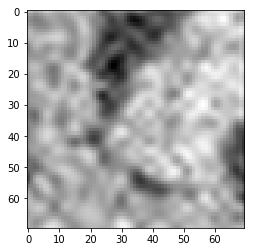

In [33]:
plt.imshow(test_output[10],cmap='gray')

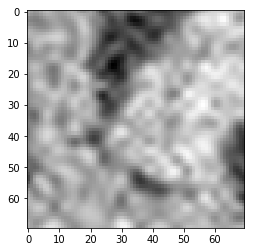

In [36]:
plt.imshow(testdataset[110,100:170,100:170],cmap='gray')

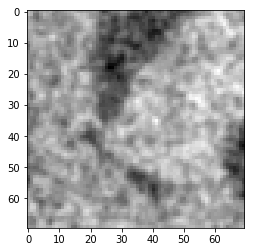

In [35]:
plt.imshow(real_image[110,100:170,100:170],cmap='gray')